# 1. Import Libraries

In [ ]:
import re
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# 2. Import & Preprocessing Datasets

In [ ]:
TOTAL_SAMPLES = 2000
MAX_LENGTH = 512

def clean_text(text):
  if not text:
    return ""
  text = re.sub(r'\s+([.,!?%:])', r'\1', text)
  return " ".join(text.split())

def filter_and_process(dataset, text_key, summary_key, style_name):
  def process_example(example):
    t_clean = clean_text(example[text_key])
    s_clean = clean_text(example[summary_key])
    
    if style_name == "Detailed":
      s_clean = clean_text(example[summary_key].lstrip('-–—').strip())
      
    return {
      'text': t_clean,
      'summary': s_clean,
      'prompt': f"Summarize {style_name}: {t_clean}",
      'word_count': len(t_clean.split())
    }

  processed_ds = dataset.map(process_example, remove_columns=dataset.column_names)
  filtered_ds = processed_ds.filter(lambda x: 0 < x['word_count'] <= MAX_LENGTH)
  
  return filtered_ds.select(range(min(TOTAL_SAMPLES, len(filtered_ds))))

xsum_raw = load_dataset('xsum', trust_remote_code=True, split='train')
cnn_raw = load_dataset('cnn_dailymail', '3.0.0', split='train')
multi_raw = load_dataset('multi_news', trust_remote_code=True, split='train')

harsh_ds = filter_and_process(xsum_raw, 'document', 'summary', 'Harsh')
balanced_ds = filter_and_process(cnn_raw, 'article', 'highlights', 'Balanced')
detailed_ds = filter_and_process(multi_raw, 'document', 'summary', 'Detailed')

def calculate_metrics(example):
  t_len = len(example['text'].split())
  s_len = len(example['summary'].split())
  return {
    'textWordCount': t_len,
    'summaryWordCount': s_len,
    'summaryPercentage': (s_len / t_len * 100) if t_len > 0 else 0
  }

harsh_df = pd.DataFrame(harsh_ds.map(calculate_metrics))
balanced_df = pd.DataFrame(balanced_ds.map(calculate_metrics))
detailed_df = pd.DataFrame(detailed_ds.map(calculate_metrics))

# 3. Exploratory Data Analysis (EDA)

In [4]:
display(harsh_df.head())
display(balanced_df.head())
display(detailed_df.head())

,summary,text,prompt,word_count,textWordCount,summaryWordCount,summaryPercentage
0,Clean-up operations are continuing across the ...,"The full cost of damage in Newton Stewart, one...",Summarize Harsh: The full cost of damage in Ne...,400,400,18,4.500000
1,Two tourist buses have been destroyed by fire ...,A fire alarm went off at the Holiday Inn in Ho...,Summarize Harsh: A fire alarm went off at the ...,155,155,17,10.967742
2,A former Lincolnshire Police officer carried o...,"John Edward Bates, formerly of Spalding, Linco...","Summarize Harsh: John Edward Bates, formerly o...",269,269,22,8.178439
3,An armed man who locked himself into a room at...,Patients and staff were evacuated from Cerahpa...,Summarize Harsh: Patients and staff were evacu...,171,171,25,14.619883
4,A man with links to a car that was involved in...,"Veronica Vanessa Chango-Alverez, 31, was kille...",Summarize Harsh: Veronica Vanessa Chango-Alver...,324,324,24,7.407407


,text,summary,prompt,word_count,textWordCount,summaryWordCount,summaryPercentage
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,"Summarize Balanced: LONDON, England (Reuters) ...",453,453,38,8.388521
1,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",Summarize Balanced: WASHINGTON (CNN) -- Doctor...,412,412,24,5.825243
2,"BOGOTA, Colombia (CNN) -- A key rebel commande...",Tomas Medina Caracas was a fugitive from a U.S...,"Summarize Balanced: BOGOTA, Colombia (CNN) -- ...",338,338,40,11.834320
3,(CNN) -- Police and FBI agents are investigati...,Empty anti-tank weapon turns up in front of Ne...,Summarize Balanced: (CNN) -- Police and FBI ag...,348,348,27,7.758621
4,"BREMEN, Germany -- Carlos Alberto, who scored ...",Werder Bremen pay a club record $10.7 million ...,"Summarize Balanced: BREMEN, Germany -- Carlos ...",297,297,35,11.784512


,summary,text,prompt,word_count,textWordCount,summaryWordCount,summaryPercentage
0,The unemployment rate dropped to 8.2% last mon...,"National Archives Yes, it’s that time again, f...","Summarize Detailed: National Archives Yes, it’...",279,279,74,26.523297
1,Howard Stern has nominated an interesting trio...,WTF?! Howard Stern recently completed the ALS ...,Summarize Detailed: WTF?! Howard Stern recentl...,139,139,106,76.258993
2,A deadly E. coli outbreak in Europe linked to ...,Article Excerpt Europeans traded blame Monday ...,Summarize Detailed: Article Excerpt Europeans ...,510,510,151,29.607843
3,Melania watchers can relax. After endless spec...,Speculations about the First Lady’s whereabout...,Summarize Detailed: Speculations about the Fir...,78,78,107,137.179487
4,One familiar face who apparently won't be appe...,"On Saturday, William Shatner took to Twitter t...","Summarize Detailed: On Saturday, William Shatn...",233,233,90,38.626609


In [5]:
def print_dataset_statistics(df, label):
  sections = [
    ('Text Word Count', 'textWordCount'),
    ('Summary Word Count', 'summaryWordCount')
  ]
    
  for i, (section_name, column) in enumerate(sections):
    print(f"=== {label} {section_name} Data ===")
    print(f"Longest Length: {df[column].max()}")
    print(f"Shortest Length: {df[column].min()}")
    print(f"Average Length: {df[column].mean():.2f}")
    print(f"Standard Deviation Length: {df[column].std():.2f}")

    if 'Summary' in section_name and 'summaryPercentage' in df.columns:
      print(f"Average Length Percentage from Text: {df.summaryPercentage.mean():.2f}%")
        
    if i < len(sections) - 1:
      print("")

print_dataset_statistics(harsh_df, 'Harsh')
print("")
print_dataset_statistics(balanced_df, 'Balanced')
print("")
print_dataset_statistics(detailed_df, 'Detailed')

=== Harsh Text Word Count Data ===
Longest Length: 512
Shortest Length: 11
Average Length: 249.22
Standard Deviation Length: 125.24

=== Harsh Summary Word Count Data ===
Longest Length: 45
Shortest Length: 1
Average Length: 20.58
Standard Deviation Length: 4.57
Average Length Percentage from Text: 11.86%

=== Balanced Text Word Count Data ===
Longest Length: 512
Shortest Length: 14
Average Length: 343.75
Standard Deviation Length: 102.99

=== Balanced Summary Word Count Data ===
Longest Length: 61
Shortest Length: 10
Average Length: 38.84
Standard Deviation Length: 7.34
Average Length Percentage from Text: 12.74%

=== Detailed Text Word Count Data ===
Longest Length: 512
Shortest Length: 20
Average Length: 347.45
Standard Deviation Length: 115.68

=== Detailed Summary Word Count Data ===
Longest Length: 444
Shortest Length: 33
Average Length: 163.06
Standard Deviation Length: 60.09
Average Length Percentage from Text: 60.56%


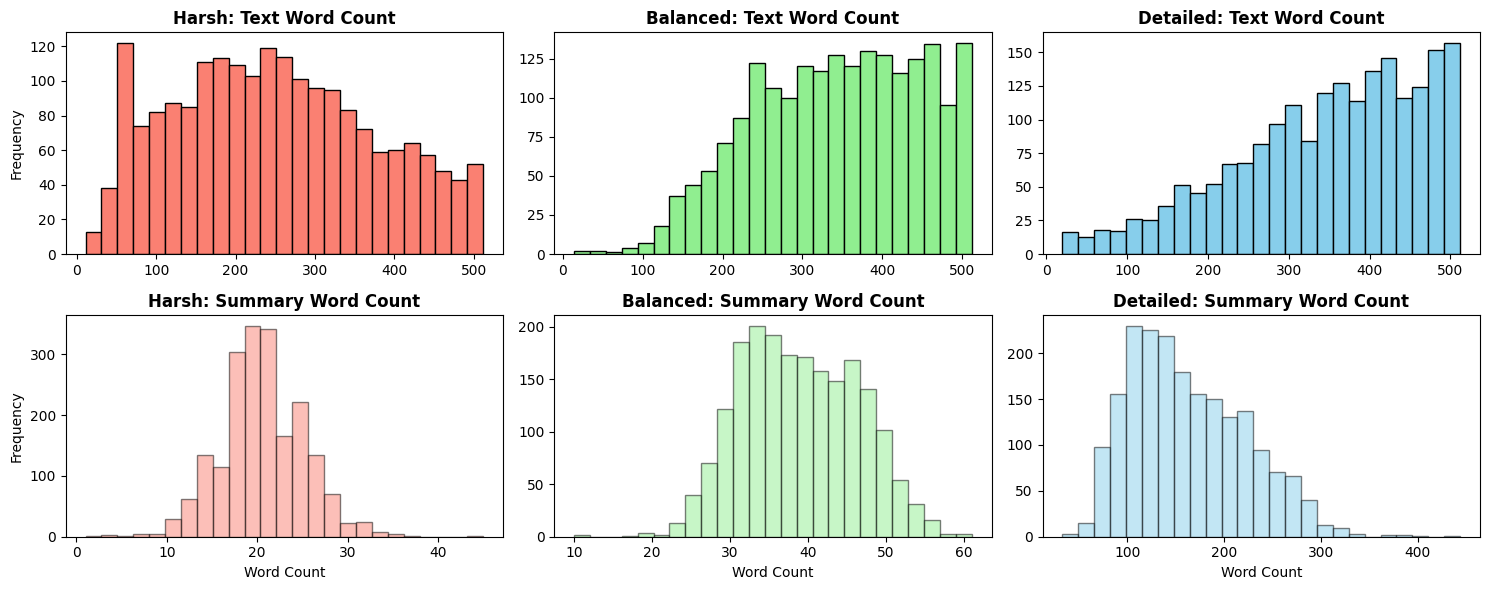

In [6]:
def plot_word_distributions(dfs, labels):
  n = len(dfs)
  plt.figure(figsize=(5 * n, 6))
  
  colors = ['salmon', 'lightgreen', 'skyblue']
  
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.hist(dfs[i]['textWordCount'], bins=25, color=colors[i], edgecolor='black', alpha=1.0)
    plt.title(f"{labels[i]}: Text Word Count", fontweight='bold')
    if i == 0:
      plt.ylabel("Frequency")

  for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.hist(dfs[i]['summaryWordCount'], bins=25, color=colors[i], edgecolor='black', alpha=0.5) 
    plt.title(f"{labels[i]}: Summary Word Count", fontweight='bold')
    plt.xlabel("Word Count")
    if i == 0:
      plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()

plot_word_distributions([harsh_df, balanced_df, detailed_df], ["Harsh", "Balanced", "Detailed"])